<a href="https://colab.research.google.com/github/Bast-94/ASL-PW/blob/main/TP_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [92]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 50,hidden_dim:int =400):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, hidden_dim)
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(hidden_dim, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(hidden_dim, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
def train_vae(vae: VAE,optimizer, train_loader,n_epochs=10,loss_function =loss_function):

  for epoch in tqdm(range(n_epochs)):
      vae.train()
      train_loss = 0
      for data, _ in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = vae(data)
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [93]:
vae(next(iter(train_loader))[0])[0].size()

torch.Size([128, 784])

In [94]:
next(iter(train_loader))[0].size()

torch.Size([128, 1, 28, 28])

## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_vae(vae,optimizer,train_loader=train_loader)

 10%|█         | 1/10 [00:18<02:44, 18.31s/it]

Epoch 0, Loss: 170.14918787434897


 20%|██        | 2/10 [00:35<02:22, 17.85s/it]

Epoch 1, Loss: 126.8990953125


 30%|███       | 3/10 [00:53<02:05, 17.96s/it]

Epoch 2, Loss: 117.39895423177083


 40%|████      | 4/10 [01:13<01:51, 18.53s/it]

Epoch 3, Loss: 113.12612736002605


 50%|█████     | 5/10 [01:31<01:32, 18.47s/it]

Epoch 4, Loss: 110.72946373697917


 60%|██████    | 6/10 [01:50<01:14, 18.69s/it]

Epoch 5, Loss: 109.25085885416667


 70%|███████   | 7/10 [02:09<00:55, 18.55s/it]

Epoch 6, Loss: 108.19667145182292


 80%|████████  | 8/10 [02:27<00:36, 18.38s/it]

Epoch 7, Loss: 107.46912755533855


 90%|█████████ | 9/10 [02:46<00:18, 18.63s/it]

Epoch 8, Loss: 106.87100400390625


100%|██████████| 10/10 [03:04<00:00, 18.46s/it]

Epoch 9, Loss: 106.4233326171875


In [96]:
def sample_from_latent_space(vae: VAE, z=None):
  if(z is None):
    z = torch.randn(vae.latent_dim)
  return vae.decode(z).view(28,28)

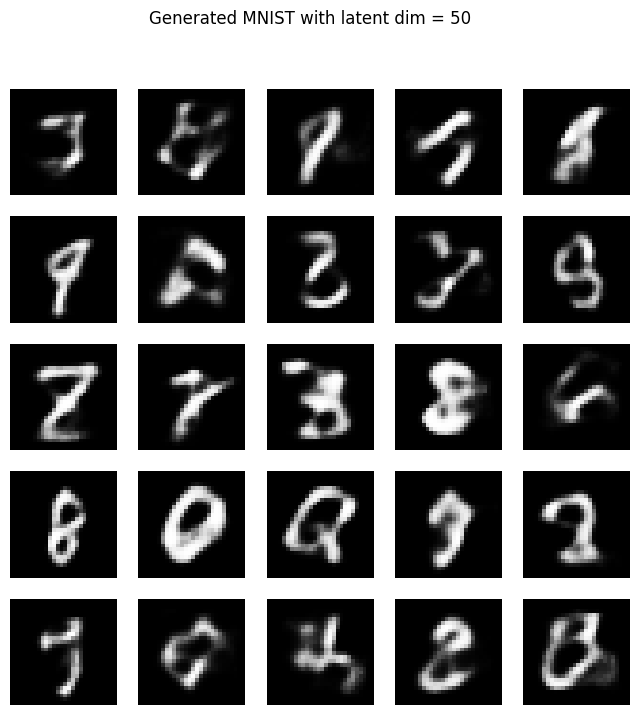

In [97]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

def generate_mnist(vae:VAE, file_name:str='generated_img.png'):
  transform = T.ToPILImage()
  col,row = 5,5
  full_size = col*row
  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Generated MNIST with latent dim = {vae.latent_dim}")
  for i in range(full_size):
    ax = fig.add_subplot(row,col,i+1)
    tensor_img = sample_from_latent_space(vae)
    img = transform(tensor_img)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
  fig.savefig(file_name)
  plt.show()

generate_mnist(vae)


Nous pouvons remarquer que le modèle peut générer des images de chiffres qui sont reconnaissables comme les 7 et les 9. Cependant ceci ne représente qu'une minorité sur les images générées. Certaines ont des formes incohérentes d'autres sont partiellement dessinées.

### Changer la dimension de l'espace latent.

Dans notre premier cas la dimension latente était de 50, nous allons la diminuer à  10 d'une part et augmenter à 100 d'autre part et observer la qualité des résultats générés mais aussi les loss respectives.

In [98]:
vae_10 = VAE(latent_dim=10)
vae_100 =  VAE(latent_dim=100)

for network in [vae_10,vae_100]:
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  train_vae(network,optimizer=optimizer,train_loader=train_loader,n_epochs=15)

  7%|▋         | 1/15 [00:17<04:07, 17.65s/it]

Epoch 0, Loss: 161.71522736002603


 13%|█▎        | 2/15 [00:35<03:49, 17.64s/it]

Epoch 1, Loss: 124.77162387695313


 20%|██        | 3/15 [00:52<03:31, 17.62s/it]

Epoch 2, Loss: 119.70924262695313


 27%|██▋       | 4/15 [01:11<03:16, 17.82s/it]

Epoch 3, Loss: 117.12742578125


 33%|███▎      | 5/15 [01:29<02:59, 17.95s/it]

Epoch 4, Loss: 115.4106284016927


 40%|████      | 6/15 [01:46<02:40, 17.85s/it]

Epoch 5, Loss: 114.18286819661458


 47%|████▋     | 7/15 [02:05<02:24, 18.10s/it]

Epoch 6, Loss: 113.2010826985677


 53%|█████▎    | 8/15 [02:23<02:06, 18.03s/it]

Epoch 7, Loss: 112.38541570638021


 60%|██████    | 9/15 [02:41<01:47, 17.96s/it]

Epoch 8, Loss: 111.68401988932291


 67%|██████▋   | 10/15 [03:01<01:33, 18.68s/it]

Epoch 9, Loss: 111.14701319986979


 73%|███████▎  | 11/15 [03:19<01:13, 18.36s/it]

Epoch 10, Loss: 110.62163012695312


 80%|████████  | 12/15 [03:36<00:54, 18.14s/it]

Epoch 11, Loss: 110.1982119954427


 87%|████████▋ | 13/15 [03:55<00:36, 18.33s/it]

Epoch 12, Loss: 109.74739908854167


 93%|█████████▎| 14/15 [04:13<00:18, 18.16s/it]

Epoch 13, Loss: 109.40316559244792


100%|██████████| 15/15 [04:31<00:00, 18.07s/it]


Epoch 14, Loss: 109.08802807617188


  7%|▋         | 1/15 [00:18<04:25, 18.97s/it]

Epoch 0, Loss: 172.58419934895832


 13%|█▎        | 2/15 [00:37<04:02, 18.67s/it]

Epoch 1, Loss: 131.42776396484376


 20%|██        | 3/15 [00:57<03:53, 19.44s/it]

Epoch 2, Loss: 120.29041310221355


 27%|██▋       | 4/15 [01:17<03:33, 19.38s/it]

Epoch 3, Loss: 114.66664156901042


 33%|███▎      | 5/15 [01:37<03:17, 19.74s/it]

Epoch 4, Loss: 111.70821036783855


 40%|████      | 6/15 [01:56<02:56, 19.57s/it]

Epoch 5, Loss: 109.76367390950521


 47%|████▋     | 7/15 [02:18<02:41, 20.16s/it]

Epoch 6, Loss: 108.56831539713542


 53%|█████▎    | 8/15 [02:37<02:19, 19.93s/it]

Epoch 7, Loss: 107.68721349283854


 60%|██████    | 9/15 [02:57<02:00, 20.02s/it]

Epoch 8, Loss: 107.02100361328125


 67%|██████▋   | 10/15 [03:17<01:38, 19.79s/it]

Epoch 9, Loss: 106.50138224283855


 73%|███████▎  | 11/15 [03:37<01:19, 19.88s/it]

Epoch 10, Loss: 106.11383989257813


 80%|████████  | 12/15 [03:56<00:59, 19.72s/it]

Epoch 11, Loss: 105.74101697591146


 87%|████████▋ | 13/15 [04:15<00:39, 19.66s/it]

Epoch 12, Loss: 105.48784464518229


 93%|█████████▎| 14/15 [04:35<00:19, 19.72s/it]

Epoch 13, Loss: 105.249259765625


100%|██████████| 15/15 [04:55<00:00, 19.68s/it]

Epoch 14, Loss: 105.00619617513021


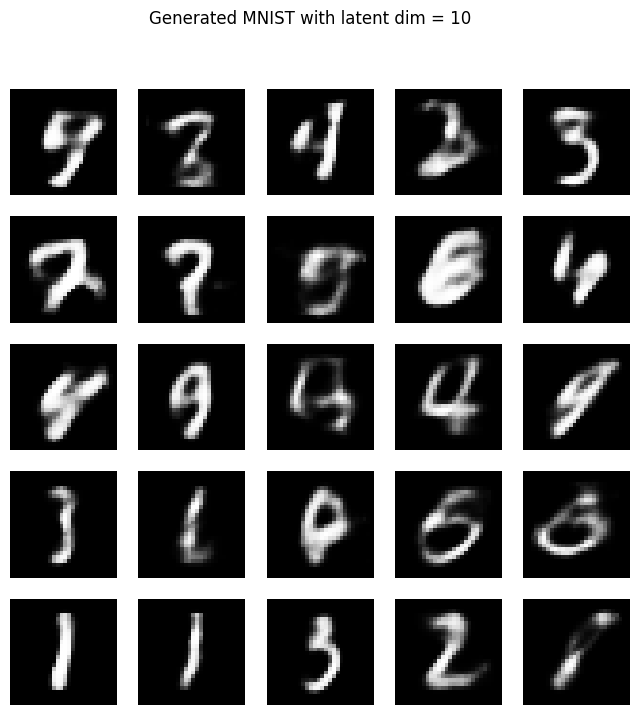

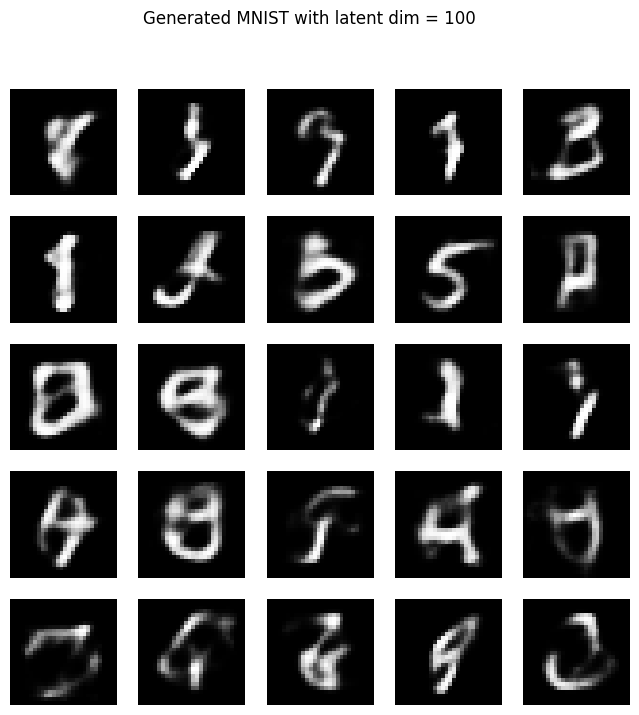

In [99]:
for network,name in zip([vae_10,vae_100],['VAE_10','VAE_100']):
  generate_mnist(network,f'{name}.png')

On remarque encore une fois que les données générées sont en majorité invraisemblables pour un humain. Notons toutefois que les chiffres 9, 7 et 1 sont reconnaissables par comparaison avec les autres.

### Changer L'architecture du VAE

L'auto-encodeur variationnel a besoin d'être adapté pour les images, il doit donc avoir des couches de convolution pour l'encodeur et le décodeur.

In [100]:
alt_train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
next(iter(alt_train_loader))[0].shape

torch.Size([128, 1, 28, 28])

In [101]:
class AltVAE(nn.Module):
    def __init__(self, latent_dim:int,n_channel:int,width:int, height:int,hidden_dim:int=512):
        super(AltVAE, self).__init__()

        # Encodeur

        self.enc = nn.Sequential(
            nn.Conv2d(n_channel, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )


        enc_output = self.enc(torch.zeros(1,n_channel,width,height))
        enc_output = enc_output.view(enc_output.shape[0],-1)
        fc_input_size = enc_output.shape[1]
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(fc_input_size, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(fc_input_size, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.enc(x))
        h1 = h1.view(h1.size(0), -1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

latent_dim = 50

sample = next(iter(alt_train_loader))[0]
my_vae = AltVAE(latent_dim,1,28,28)
xhat, mean, log_var = my_vae(sample)
output_shape = sample.view(len(sample),-1).shape
assert xhat.shape == output_shape
assert len(mean.shape) == 2 and mean.shape[1] == latent_dim
assert len(log_var.shape) == 2 and log_var.shape[1] == latent_dim
print("Les shapes du VAE sont cohérentes")

Les shapes du VAE sont cohérentes


### Paramétrer la fonction loss pour pondérer les deux termes

Nous allons créer une fonction de loss qui puisse apprendre à paramétrer la pondération des deux termes

In [102]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return self.alpha * BCE + self.beta * KLD


In [103]:
my_vae = AltVAE(latent_dim,1,28,28,512).to(device)
optimizer = torch.optim.Adam(my_vae.parameters(), lr=1e-3)
loss_func = CustomLoss()
n_epochs =10

for epoch in (range(n_epochs)):
      my_vae.train()
      train_loss = 0
      for data, _ in tqdm(train_loader):
          data = data.to(device)

          optimizer.zero_grad()
          recon_batch, mu, logvar = my_vae(data)
          loss = loss_func(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(alt_train_loader.dataset)}')


100%|██████████| 469/469 [01:29<00:00,  5.21it/s]


Epoch 0, Loss: 171.08447862955728


100%|██████████| 469/469 [01:31<00:00,  5.12it/s]


Epoch 1, Loss: 123.33128637695313


100%|██████████| 469/469 [01:34<00:00,  4.96it/s]


Epoch 2, Loss: 114.92698746744792


100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 3, Loss: 111.36657631835938


100%|██████████| 469/469 [01:31<00:00,  5.10it/s]


Epoch 4, Loss: 109.24581858723958


100%|██████████| 469/469 [01:32<00:00,  5.04it/s]


Epoch 5, Loss: 107.98443297526042


100%|██████████| 469/469 [01:32<00:00,  5.06it/s]


Epoch 6, Loss: 107.09037231445312


100%|██████████| 469/469 [01:31<00:00,  5.13it/s]


Epoch 7, Loss: 106.38841438802083


100%|██████████| 469/469 [01:31<00:00,  5.11it/s]


Epoch 8, Loss: 105.9230858561198


100%|██████████| 469/469 [01:35<00:00,  4.93it/s]

Epoch 9, Loss: 105.52405346679687


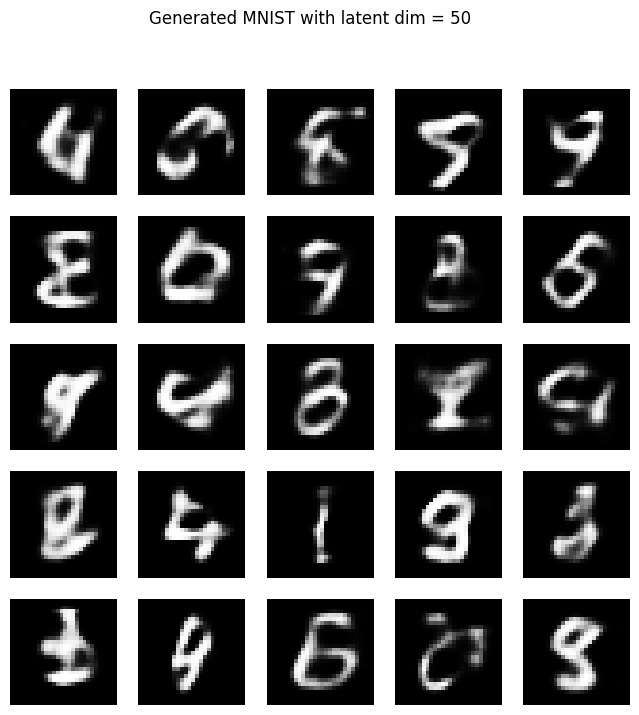

In [104]:
generate_mnist(my_vae,file_name='self_vae.png')